In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# load the cleaned data
user_data_df = pd.read_csv('./user_data_cleaned.csv', index_col=0)
user_data_df['airing_start_date'] = pd.to_datetime(user_data_df['airing_start_date'])


In [68]:
import sys

# add utils to the path
sys.path.append('/mnt/data/workspace/machine-learning/src')

import numpy as np
from util.transformers import StringSplitter, IgnoreNotSeen, Raiser, RelatedMapper, ListNGramer
from sklearn.base import TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Binarizer, MultiLabelBinarizer, \
    LabelEncoder, OneHotEncoder, Imputer, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn_pandas import CategoricalImputer, DataFrameMapper, gen_features

# generate the dfifferent train and test datasets
df = user_data_df.copy()
binarizer = Binarizer(threshold=6) 
df['liked'] = binarizer.fit_transform(df.score.values.reshape(-1, 1))

train = df[(df['airing_start_date'] >= '2014-01-01') & (df['airing_start_date'] < '2016-06-01')]
test = df[(df['airing_start_date'] >= '2016-06-01') ]

dev_test, test = train_test_split(
    test, random_state=15, test_size=0.5, stratify=test.liked 
)

# map features
feature_mapper = DataFrameMapper(
    gen_features(
        columns=['source', 'type', 'rating'],
        classes=[
            {'class': IgnoreNotSeen, 'flatten': False},
            {'class': CategoricalImputer},
            {'class': LabelEncoder},
            {'class': Raiser},
            {'class': OneHotEncoder},
        ]
    ) + gen_features(
        columns=['genres', 'studios'],
        classes=[
            {'class': StringSplitter},
            {'class': IgnoreNotSeen, 'flatten': True},
            {'class': MultiLabelBinarizer},
            {'class': PCA, 'n_components': 20},
        ]
    ) + [
        ('related', [
            RelatedMapper({str(row.series_id): row.score for index, row in train.iterrows()}, 0.),
            Raiser(),
            Binarizer(threshold=6),
        ]),
    ],
    df_out=True
)

feature_mapper.fit(train)

# split X and y
y_train = train.liked
X_train = feature_mapper.transform(train)
y_dev_test = dev_test.liked
X_dev_test = feature_mapper.transform(dev_test)
y_test = test.liked
X_test = feature_mapper.transform(test)
print('Train length: {}; Dev Test Length: {}; Test Length: {}'.format(
    len(train), len(dev_test), len(test)
))

Train length: 272; Dev Test Length: 67; Test Length: 68


<IPython.core.display.Javascript object>


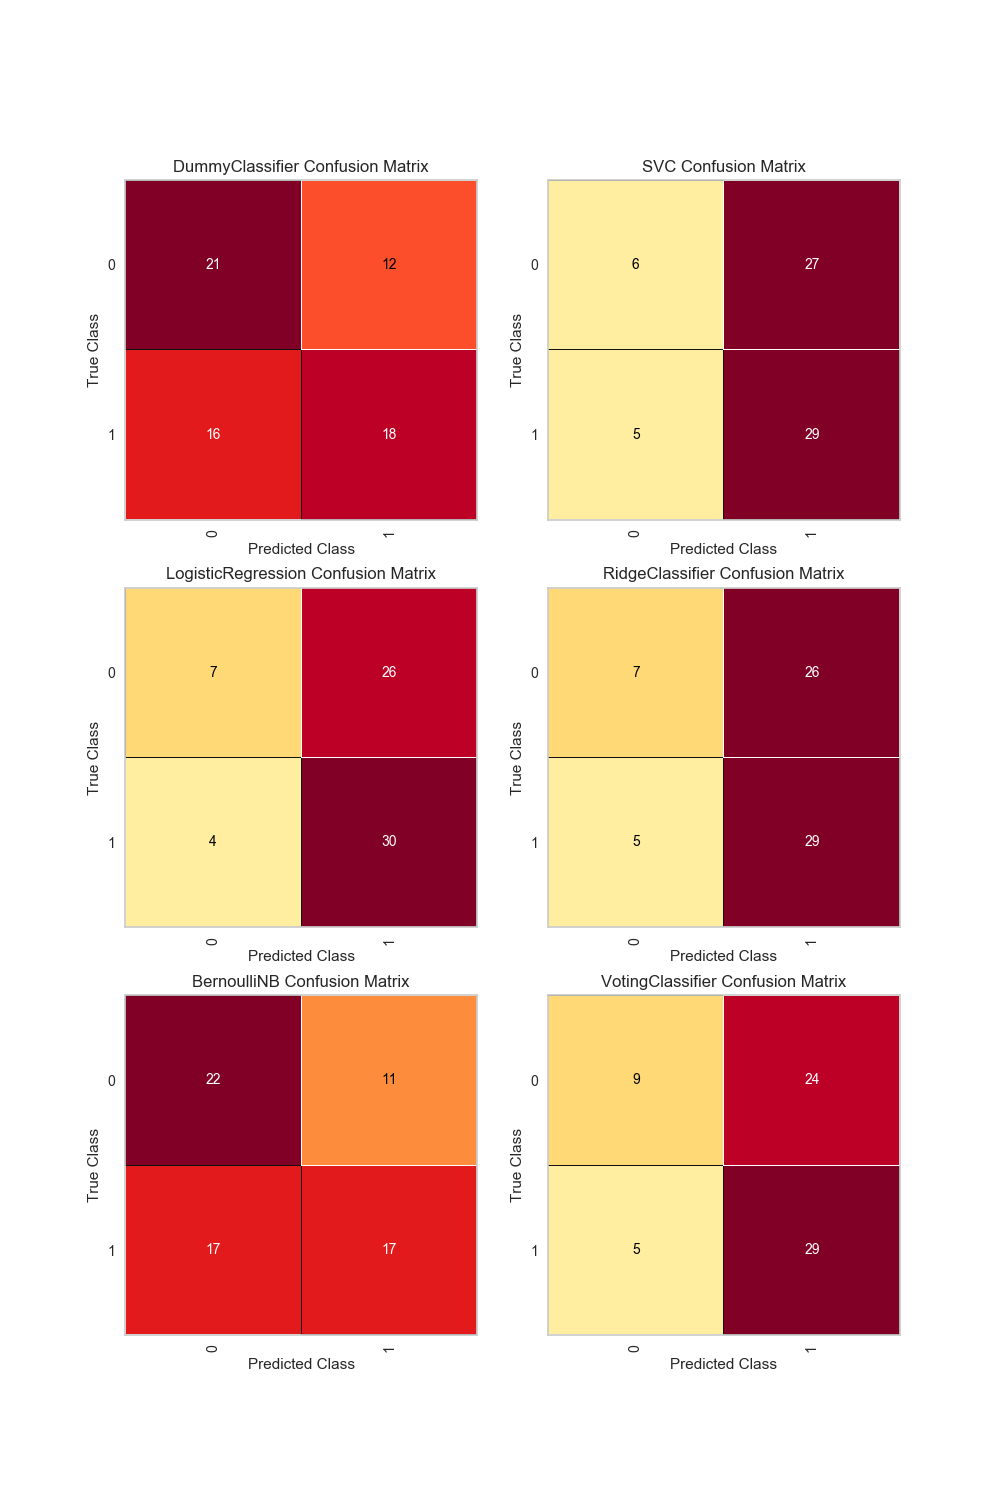

/mnt/data/workspace/machine-learning/env/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/mnt/data/workspace/machine-learning/env/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/mnt/data/workspace/machine-learning/env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [83]:
import numpy as np
from sklearn.dummy import DummyClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier, LogisticRegression, RidgeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from yellowbrick.classifier import ConfusionMatrix
# from yellowbrick.model_selection import ValidationCurve
import matplotlib.pyplot as plt
%matplotlib notebook

fig = plt.figure(figsize=(10, 15))
ax1 = fig.add_subplot(321)
ax2 = fig.add_subplot(322)
ax3 = fig.add_subplot(323)
ax4 = fig.add_subplot(324)
ax5 = fig.add_subplot(325)
ax6 = fig.add_subplot(326)

# Instantiate the classification model and visualizer
baseline = DummyClassifier()
model1 = SVC(kernel='linear', max_iter=500, C=100)
model2 = LogisticRegression(max_iter=500, C=1, penalty='l1')
model3 = RidgeClassifier(max_iter=500, alpha=10)
model4 = BernoulliNB(alpha=0.5)
model5 = VotingClassifier([
    ('model1', model1),
    ('model2', model2),
    ('model3', model3),
    ('model4', model4),
], voting='hard' )

baseline_visualizer = ConfusionMatrix(baseline, ax=ax1)
visualizer1 = ConfusionMatrix(model1, ax=ax2)
visualizer2 = ConfusionMatrix(model2, ax=ax3)
visualizer3 = ConfusionMatrix(model3, ax=ax4)
visualizer4 = ConfusionMatrix(model4, ax=ax5)
visualizer5 = ConfusionMatrix(model5, ax=ax6)
# visualizer = ValidationCurve(
#     model, param_name="alpha", param_range=np.arange(10, 100, 5), scoring='f1'
# ) 

baseline_visualizer.fit(X_train, y_train)
baseline_visualizer.score(X_dev_test, y_dev_test)
baseline_visualizer.poof()

visualizer1.fit(X_train, y_train)
visualizer1.score(X_dev_test, y_dev_test)
visualizer1.poof()

visualizer2.fit(X_train, y_train)
visualizer2.score(X_dev_test, y_dev_test)
visualizer2.poof()

visualizer3.fit(X_train, y_train)
visualizer3.score(X_dev_test, y_dev_test)
visualizer3.poof()

visualizer4.fit(X_train, y_train)
visualizer4.score(X_dev_test, y_dev_test)
visualizer4.poof()

visualizer5.fit(X_train, y_train)
visualizer5.score(X_dev_test, y_dev_test)
visualizer5.poof()